In [207]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [208]:
df = pd.read_csv('./OnlineNewsPopularity.csv')
df = df.drop(df.columns[list(range(0,2))+list(range(4,7))+list(range(13,39))+list([60])],axis = 1)
df = df.iloc[0:5000,:]
dataset = np.array(df)

In [209]:
def generate_kernel(dataset,kernel,spread = None):
    empty_kernel = np.zeros((dataset.shape[0],dataset.shape[0]))
    for i in range(dataset.shape[0]):
        for j in range(i,dataset.shape[0]):
            X = dataset[i,:]
            Y = dataset[j,:]
            if kernel == 'linear':
                K_ij = compute_linear_kernel(X,Y)
            if kernel == 'gaussian':
                K_ij = compute_gaussian_kernel(X,Y,spread)
            empty_kernel[i][j] = K_ij
            empty_kernel[j][i] = K_ij
    return  empty_kernel

def compute_linear_kernel(X,Y):
    return np.dot(X.T,Y)     

def compute_gaussian_kernel(X,Y,spread):
	return np.exp(-1 * (np.linalg.norm(X - Y)**2 / (2 * spread)) )

def center_kernel(kernel):
    coeffs = np.eye(kernel.shape[0]) - (1/(kernel.shape[0])*np.ones((kernel.shape[0],kernel.shape[1])))
    centered_kernel = np.dot(np.dot(coeffs,kernel),coeffs)
    return centered_kernel

def compute_eigens(centered_kernel):
    eigen_values,eigen_vectors = np.linalg.eigh(centered_kernel)
    eigen_values = eigen_values[::-1]
    eigen_vectors = eigen_vectors[:, ::-1]
    return eigen_values, eigen_vectors

def compute_variance(eigen_values,n):
    variance = []
    for i in eigen_values:
        variance.append(i/n)
    return variance

def normalize_eigen_vectors(eigen_vectors,eigen_values):
    for i in range(len(eigen_values)):
        eigen_vectors[:,i] = np.sqrt(1/abs(eigen_values[i]))*eigen_vectors[:,i]
    return eigen_vectors

def fraction_of_total_variance(variance,n):
    total_var = sum(variance)
    var_to_n = sum(variance[:n])
    return var_to_n/total_var

def project_data(eigen_vectors,centered_kernel):
    basis = np.column_stack([eigen_vectors[:, 1-i]
                           for i in range(2)])    
    projection = np.dot(basis.T,centered_kernel)
    return projection

In [210]:
linear_kernel = generate_kernel(dataset,'linear')
centered_kernel = center_kernel(linear_kernel)
eigen_values,eigen_vectors = compute_eigens(centered_kernel)
variance = compute_variance(eigen_values,linear_kernel.shape[0])
eigen_vectors = normalize_eigen_vectors(eigen_vectors,eigen_values)
fraction_of_total_variance(variance,1)

0.9989247809519929

# Thus, one pricipal component would capture more than 0.95 fraction of the total variance

# Plot the projected data using scatter plot with Linear Kernel PCA

<AxesSubplot:xlabel='pc2', ylabel='pc1'>

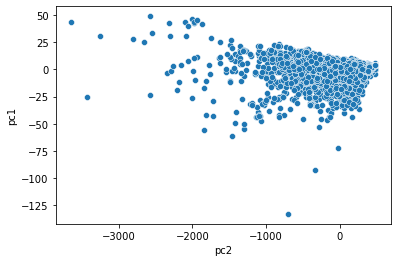

In [211]:
projection = pd.DataFrame(project_data(eigen_vectors,centered_kernel).T,columns=['pc1','pc2'])
sns.scatterplot(data = projection, x= 'pc2',y = 'pc1')

# Plot the projected data using scatter plot with Regular PCA

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

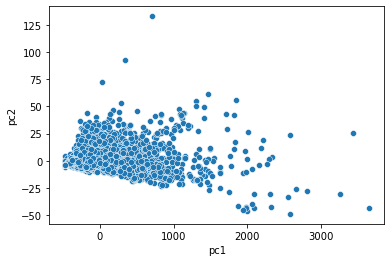

In [212]:
#code from last homework

## helper functions
def length(a):
    return np.sqrt(np.dot(a.T,a))
def normalize(a):
    return a/length(a)
def get_cov(X,X_mean):
    return (np.dot((X-X_mean).T,(X-X_mean))/X.shape[0])
def get_mean(X):
    return X.sum(axis=0) / X.shape[0]
def total_variance(X,X_mean):
    return np.sum((X-X_mean)**2) / X.shape[0]
A = df.to_numpy()
A = A - get_mean(A)
d = A.shape[1]
epsilon = 10e-6
intermediate_result = list()
X_i = np.random.rand(d,2)
X_i[:,0] = normalize(X_i[:,0])
X_i[:,1] = normalize(X_i[:,1])
cov = get_cov(A,get_mean(A))
while len(intermediate_result)<2 or np.linalg.norm(intermediate_result[-1] - intermediate_result[-2])>=epsilon:
    X_iplus1 = np.dot(cov,X_i)
    X_iplus1[:,1] = X_iplus1[:,1] - np.dot((np.dot(X_iplus1[:,1].T,X_iplus1[:,0])/np.dot(X_iplus1[:,0].T,X_iplus1[:,0])),X_iplus1[:,0])
    X_iplus1[:,0] = normalize(X_iplus1[:,0])
    X_iplus1[:,1] = normalize(X_iplus1[:,1])
    X_i = X_iplus1
    intermediate_result.append(X_iplus1)
u_1 = X_iplus1[:,0]
u_2 = X_iplus1[:,1]
first_PC = np.dot(A, u_1)
second_PC = np.dot(A, u_2)
pc = np.concatenate((first_PC.reshape(-1,1),second_PC.reshape(-1,1)),axis = 1)
pc = pd.DataFrame(pc,columns=['pc1','pc2'])
sns.scatterplot(data = pc, x= 'pc1',y = 'pc2')

# Comparison between linear kernel and the original PCA: They are genuinely the same, except that the images are flipped (probably because there are positive and negative eigenvalues for the same value and power iteration and eigeh picked the different values)

# Plot the projection using a gaussian kernel 

In [213]:
gaussian_kernel = generate_kernel(dataset,'gaussian',0.8)
centered_kernel = center_kernel(gaussian_kernel)
eigen_values,eigen_vectors = compute_eigens(centered_kernel)
variance = compute_variance(eigen_values,gaussian_kernel.shape[0])
eigen_vectors = normalize_eigen_vectors(eigen_vectors,eigen_values)
fraction_of_total_variance(variance,1)

In [ ]:
fraction_of_total_variance(variance,4000)

0.8105609006412113

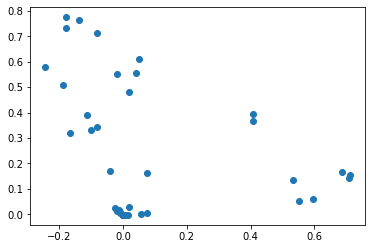

In [ ]:
projection = project_data(eigen_vectors,centered_kernel)
plt.scatter(x = projection[0], y = projection[1])

# I chose spread = 0.8 since the data in the graph are most dense.

# The projection mostly looks the same. I think the main reason here that is the dataset itself does not follow a normal distribution 